In [1]:
import sys, os, distutils.core
from IPython.display import clear_output

!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 7.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=ff87a5150a877d3a1ebf439bde58d16e65a633014e08a04a6392113ce4f1d52c
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask 2023.9.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
dask-cuda 23.8.0 requires dask==2023.7.1, but you have dask 2023.9.0 which is incompatible.
dask-c

In [2]:
# Importing dependencies

import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 10
THRESHOLD = 0.8

detectron2 version: 0.6


In [3]:
# Creating coco instances

from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

    
register_coco_instances(f"tomato_dataset_train", {},
                        f"/kaggle/input/tomatod/annotations/tomatOD_train.json",
                        f"/kaggle/input/tomatod/images/train")

register_coco_instances(f"tomato_dataset_test", {},
                        f"/kaggle/input/tomatod/annotations/tomatOD_test.json",
                        f"/kaggle/input/tomatod/images/val")

In [4]:
import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("tomato_dataset_train")
train_dataset_dicts = DatasetCatalog.get("tomato_dataset_train")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]
    
    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()
        
        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

[06/04 15:03:23 d2.data.datasets.coco]: Loaded 222 images in COCO format from /kaggle/input/tomatod/annotations/tomatOD_train.json


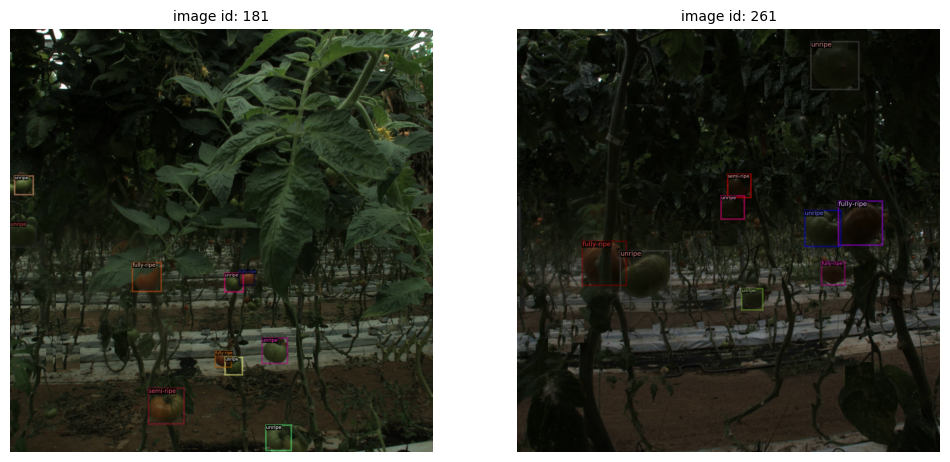

In [5]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 5, image_scale = 1)

In [6]:
import os
import logging
import time
from detectron2.engine import DefaultTrainer, HookBase
from detectron2.config import get_cfg
from detectron2 import model_zoo
from tabulate import tabulate

# Configure logging
log_file = 'training_log.txt'
logging.basicConfig(filename=log_file, level=logging.INFO)

# Print message to console to confirm logging setup
print(f"Logging to {log_file}")

# List of learning rates to experiment with
learning_rates = [0.001, 0.005, 0.01]

# Number of iterations and runs
num_iterations = 1000
num_runs = 10

# Data structure to store results
results = []

# Custom hook to log the training progress
class LossLoggerHook(HookBase):
    def __init__(self):
        super().__init__()

    def after_step(self):
        if self.trainer.storage.iter % 20 == 0:  # Log every 20 iterations
            total_loss = self.trainer.storage.history("total_loss").latest()
            logging.info(f"iter: {self.trainer.storage.iter} total_loss: {total_loss}")
            print(f"Logged iteration {self.trainer.storage.iter}")

# Function to train with a specific learning rate
def train_with_learning_rate(lr):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ('tomato_dataset_train',)
    cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.MAX_ITER = num_iterations
    cfg.SOLVER.STEPS = []  # do not decay learning rate
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
    cfg.SOLVER.BASE_LR = lr  # Set learning rate

    # Implement gradient clipping correctly
    cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
    cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
    cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.register_hooks([LossLoggerHook()])

    start_time = time.time()
    trainer.resume_or_load(resume=False)
    trainer.train()
    end_time = time.time()

    # Get the minimum loss over all iterations
    min_loss = min(trainer.storage.history("total_loss").values())

    return min_loss, end_time - start_time

# Run training for each learning rate
for lr in learning_rates:
    lr_results = []
    for run in range(num_runs):
        logging.info(f"Starting training with learning rate: {lr}, run: {run + 1}")
        print(f"Starting training with learning rate: {lr}, run: {run + 1}")
        min_loss, duration = train_with_learning_rate(lr)
        lr_results.append([lr, run + 1, min_loss, duration])
    results.extend(lr_results)

# Aggregate results for each learning rate
summary_results = []
for lr in learning_rates:
    lr_runs = [result for result in results if result[0] == lr]
    min_loss = min(lr_runs, key=lambda x: x[2])[2]
    total_time = sum(run[3] for run in lr_runs)
    summary_results.append([lr, min_loss, total_time])

# Tabulate the detailed results for each run
headers = ["Learning Rate", "Run", "Minimum Loss", "Duration (s)"]
print(tabulate(results, headers, floatfmt=".6f"))

# Log the detailed results to the file
logging.info(tabulate(results, headers, floatfmt=".6f"))

# Tabulate and print the summary results
summary_headers = ["Learning Rate", "Minimum Loss", "Total Time (s)"]
print(tabulate(summary_results, summary_headers, floatfmt=".6f"))

# Log the summary results to the file
logging.info(tabulate(summary_results, summary_headers, floatfmt=".6f"))

# Tabulate the detailed results for each learning rate
for lr in learning_rates:
    lr_runs = [result for result in results if result[0] == lr]
    print(f"\nDetailed results for learning rate: {lr}")
    print(tabulate(lr_runs, headers, floatfmt=".6f"))
    logging.info(f"\nDetailed results for learning rate: {lr}")
    logging.info(tabulate(lr_runs, headers, floatfmt=".6f"))


Logging to training_log.txt
Starting training with learning rate: 0.001, run: 1
[06/04 15:03:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (n

model_final_f6e8b1.pkl: 243MB [00:01, 216MB/s]                             


[06/04 15:03:29 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Logged iteration 0
[06/04 15:03:39 d2.utils.events]:  eta: 0:05:22  iter: 19  total_loss: 2.376  loss_cls: 1.556  loss_box_reg: 0.6415  loss_rpn_cls: 0.1259  loss_rpn_loc: 0.05163    time: 0.3270  last_time: 0.2966  data_time: 0.0187  last_data_time: 0.0050   lr: 1.9981e-05  max_mem: 2391M


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Logged iteration 20
[06/04 15:03:54 d2.utils.events]:  eta: 0:04:52  iter: 39  total_loss: 2.151  loss_cls: 1.478  loss_box_reg: 0.6153  loss_rpn_cls: 0.06158  loss_rpn_loc: 0.03946    time: 0.3126  last_time: 0.2875  data_time: 0.0054  last_data_time: 0.0060   lr: 3.9961e-05  max_mem: 2391M
Logged iteration 40
[06/04 15:04:00 d2.utils.events]:  eta: 0:04:42  iter: 59  total_loss: 2.028  loss_cls: 1.302  loss_box_reg: 0.6541  loss_rpn_cls: 0.04187  loss_rpn_loc: 0.04095    time: 0.3064  last_time: 0.2808  data_time: 0.0055  last_data_time: 0.0055   lr: 5.9941e-05  max_mem: 2391M
Logged iteration 60
[06/04 15:04:06 d2.utils.events]:  eta: 0:04:38  iter: 79  total_loss: 1.8  loss_cls: 1.095  loss_box_reg: 0.6187  loss_rpn_cls: 0.03286  loss_rpn_loc: 0.03755    time: 0.3080  last_time: 0.3216  data_time: 0.0056  last_data_time: 0.0055   lr: 7.9921e-05  max_mem: 2391M
Logged iteration 80
[06/04 15:04:12 d2.utils.events]:  eta: 0:04:32  iter: 99  total_loss: 1.49  loss_cls: 0.771  loss_box_

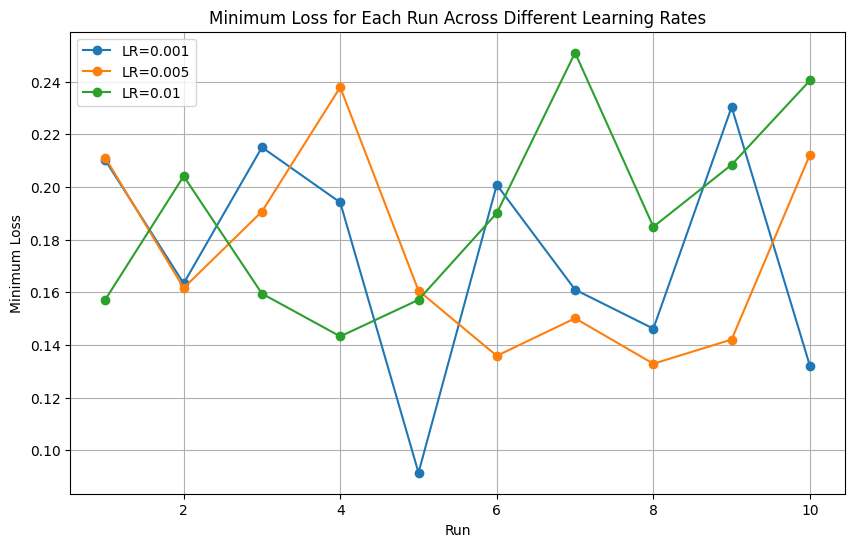

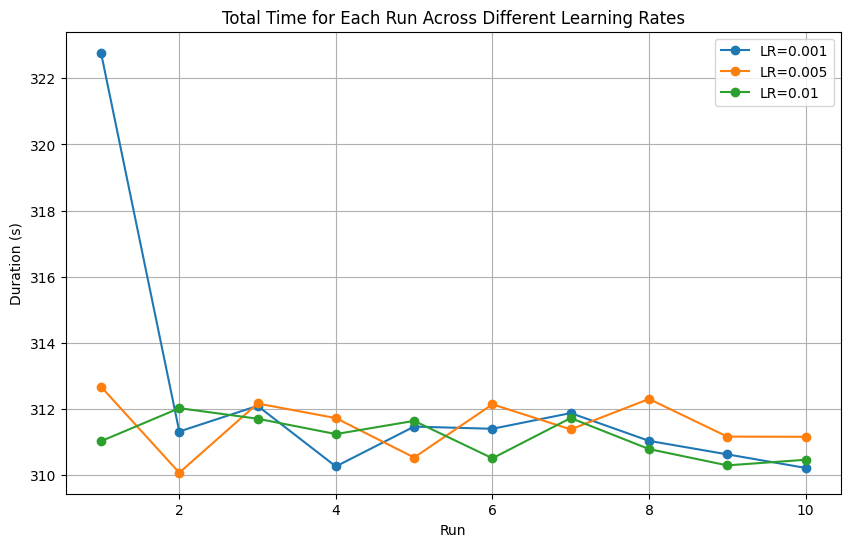

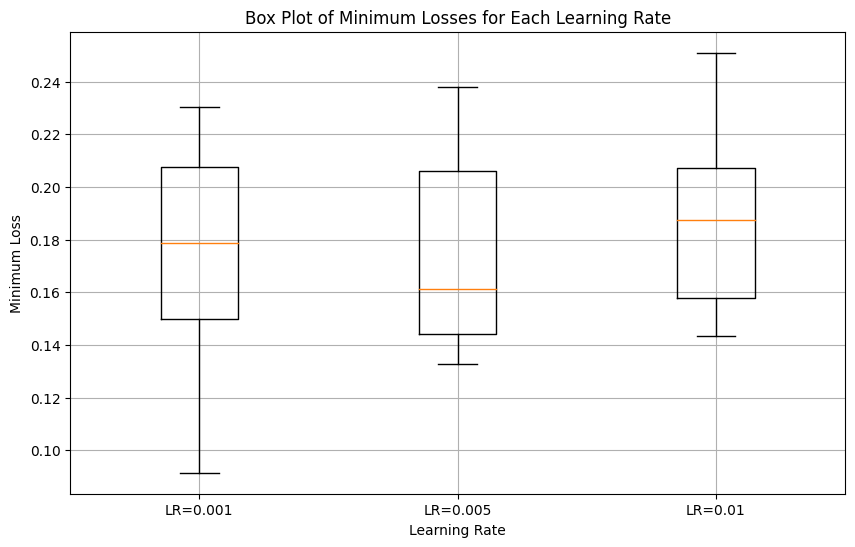

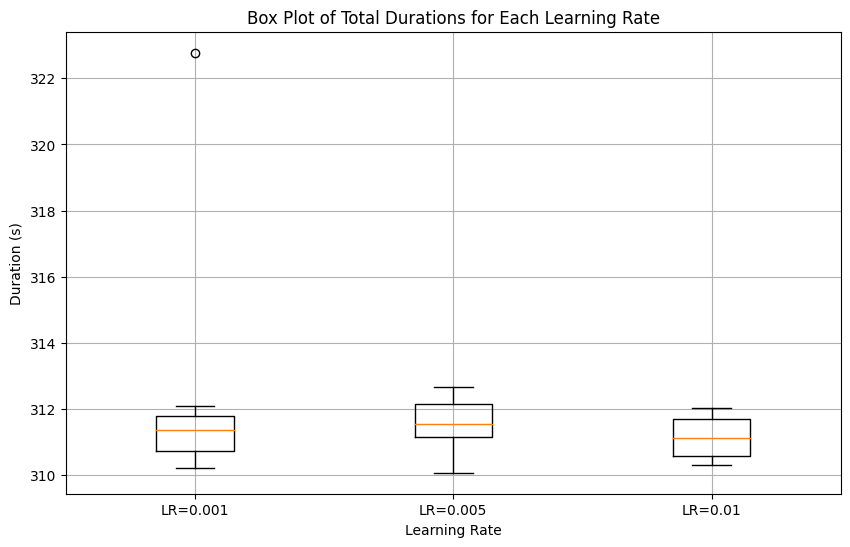

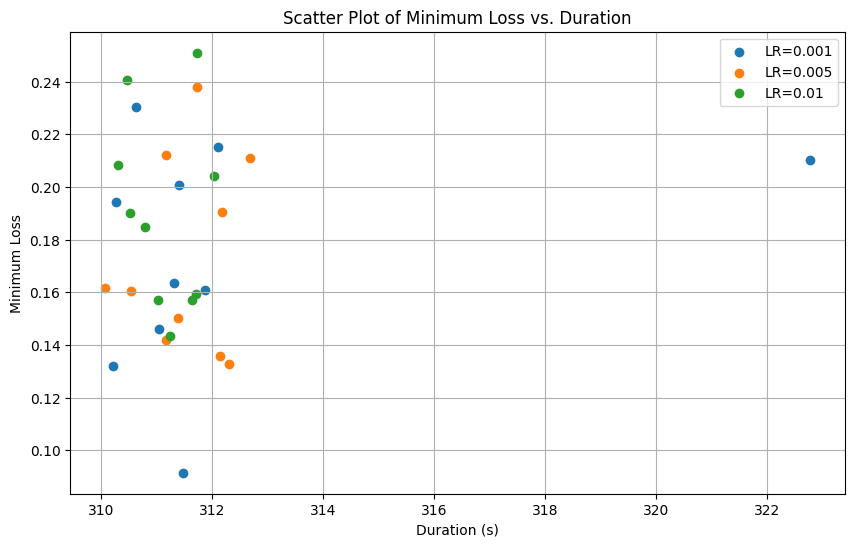

In [7]:
import matplotlib.pyplot as plt

# Assuming `results` is a list of lists with the structure [learning_rate, run, (min_loss, iteration), duration]

# Extract data for plotting
learning_rates = sorted(set(result[0] for result in results))
num_runs = len([result for result in results if result[0] == learning_rates[0]])

# Prepare data for plotting
loss_data = {lr: [] for lr in learning_rates}
time_data = {lr: [] for lr in learning_rates}

for result in results:
    lr, run, (min_loss, _), duration = result
    loss_data[lr].append(min_loss)
    time_data[lr].append(duration)

# Plot minimum loss for each run
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(range(1, num_runs + 1), loss_data[lr], marker='o', label=f'LR={lr}')
plt.xlabel('Run')
plt.ylabel('Minimum Loss')
plt.title('Minimum Loss for Each Run Across Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

# Plot total time for each run
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(range(1, num_runs + 1), time_data[lr], marker='o', label=f'LR={lr}')
plt.xlabel('Run')
plt.ylabel('Duration (s)')
plt.title('Total Time for Each Run Across Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

# Box plot of minimum losses
plt.figure(figsize=(10, 6))
plt.boxplot([loss_data[lr] for lr in learning_rates], labels=[f'LR={lr}' for lr in learning_rates])
plt.xlabel('Learning Rate')
plt.ylabel('Minimum Loss')
plt.title('Box Plot of Minimum Losses for Each Learning Rate')
plt.grid(True)
plt.show()

# Box plot of total durations
plt.figure(figsize=(10, 6))
plt.boxplot([time_data[lr] for lr in learning_rates], labels=[f'LR={lr}' for lr in learning_rates])
plt.xlabel('Learning Rate')
plt.ylabel('Duration (s)')
plt.title('Box Plot of Total Durations for Each Learning Rate')
plt.grid(True)
plt.show()

# Scatter plot of minimum loss vs. duration
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.scatter(time_data[lr], loss_data[lr], label=f'LR={lr}')
plt.xlabel('Duration (s)')
plt.ylabel('Minimum Loss')
plt.title('Scatter Plot of Minimum Loss vs. Duration')
plt.legend()
plt.grid(True)
plt.show()
